In [1]:
# Colab Venn Diagram
!pip install -q matplotlib-venn

In [19]:
import io
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3
from google.colab import files

In [20]:
uploaded = files.upload()
file_path = list(uploaded.keys())[0]
data = pd.read_csv(file_path)

Saving Data Parkison y.csv to Data Parkison y.csv


In [21]:
# Read the data into df
df = data

In [22]:
display(df.head())

,Gene names,Alpha A30P_day_1,Alpha A30P_day_10,Alpha A53T_day_1,Alpha A53T_day_10,Alpha A53T_day_30,Alpha_day_1,Alpha _day_10,Alpha _day_30
0,NaN,0.564615,0.377385,0.5028,0.311625,0.20518,0.45222,#DIV/0!,0.51015
1,dnc,0.238265,0.256235,0.43895,0.21388,0.2204,0.36847,0.30716,0.206455
2,NaN,0.25264,0.315085,0.36425,0.17219,0.211605,#DIV/0!,0.504575,0.87663
3,Marf,0.410335,0.272485,0.495645,0.36234,0.25335,0.463215,0.28664,0.5957
4,Rh4,0.912605,0.6073855,#DIV/0!,0.45079,0.4548,0.77382,#DIV/0!,0.12322


In [23]:
# Sanity check: ensure expected columns exist
#expected_cols = {"Gene Name", "Sample A", "Sample B", "Sample C"}
#missing = expected_cols - set(df.columns)
#if missing:
    #raise ValueError(f"Missing expected columns: {missing}. Found columns: {list(df.columns)}")

In [27]:
# Define presence rule
THRESH = 0   # treat values > THRESH as present

# Clean non-numeric values (e.g., '#VALUE!') by converting to NaN
# This loop should ideally only run once or be optimized if performance is critical
for col in df.columns:
    if col != "Gene names": # Do not try to convert the 'Gene names' column
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Identify relevant columns for each set based on keywords
sample_A_cols = [col for col in df.columns if col.startswith('Alpha')]
sample_B_cols = [col for col in df.columns if 'A30P' in col]
sample_C_cols = [col for col in df.columns if 'A53T' in col]

# Initialize empty sets to store gene names
set_A = set()
set_B = set()
set_C = set()

# Populate set_A: Genes with a value > THRESH in any 'Alpha' column
# Ensure there are columns to process before attempting to create the mask
if sample_A_cols:
    mask_A = (df[sample_A_cols].notna() & (df[sample_A_cols] > THRESH)).any(axis=1)
    set_A = set(df.loc[mask_A, "Gene names"].astype(str).dropna())

# Populate set_B: Genes with a value > THRESH in any 'A30P' column
if sample_B_cols:
    mask_B = (df[sample_B_cols].notna() & (df[sample_B_cols] > THRESH)).any(axis=1)
    set_B = set(df.loc[mask_B, "Gene names"].astype(str).dropna())

# Populate set_C: Genes with a value > THRESH in any 'A53T' column
if sample_C_cols:
    mask_C = (df[sample_C_cols].notna() & (df[sample_C_cols] > THRESH)).any(axis=1)
    set_C = set(df.loc[mask_C, "Gene names"].astype(str).dropna())


In [30]:
# Build & save Venn diagram
only_A = len(set_A - set_B - set_C)
only_B = len(set_B - set_A - set_C)
A_B    = len((set_A & set_B) - set_C)
only_C = len(set_C - set_A - set_B)
A_C    = len((set_A & set_C) - set_B)
B_C    = len((set_B & set_C) - set_A)
A_B_C  = len(set_A & set_B & set_C)


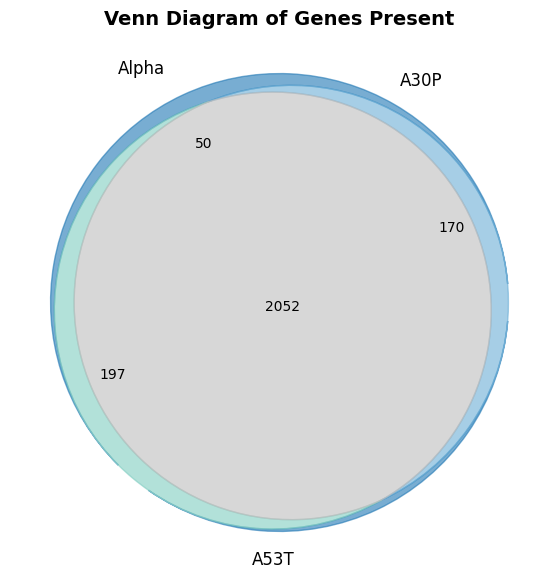

In [32]:
# Plot
plt.figure(figsize=(7,7))
v = venn3(subsets=(only_A, only_B, A_B, only_C, A_C, B_C, A_B_C),
          set_labels=("Alpha", "A30P", "A53T"))


# Apply custom colors
patch_100 = v.get_patch_by_id('100')
if patch_100: patch_100.set_color('#1f77b4')  # A only (blue)
patch_010 = v.get_patch_by_id('010')
if patch_010: patch_010.set_color('#ff7f0e')  # B only (orange)
patch_001 = v.get_patch_by_id('001')
if patch_001: patch_001.set_color('#2ca02c')  # C only (green)
patch_110 = v.get_patch_by_id('110')
if patch_110: patch_110.set_color('#6baed6')  # A∩B
patch_101 = v.get_patch_by_id('101')
if patch_101: patch_101.set_color('#80cdc1')  # A∩C
patch_011 = v.get_patch_by_id('011')
if patch_011: patch_011.set_color('#fdae6b')  # B∩C
patch_111 = v.get_patch_by_id('111')
if patch_111: patch_111.set_color('#bdbdbd')  # A∩B∩C


# set transparency for all areas
for patch in v.patches:
    if patch:
        patch.set_alpha(0.6)

plt.title("Venn Diagram of Genes Present", fontsize=14, fontweight='bold')

# Save outputs
png_path = "Venn_Sheet1_colored.png"
pdf_path = "Venn_Sheet1_colored.pdf"
plt.savefig(png_path, dpi=600, format="png")
plt.savefig(pdf_path, format="pdf")
plt.show()

In [34]:
# Define a function to get genes for a given subset
def genes_for(subset_id):
    if subset_id == '100':
        return list(set_A - set_B - set_C)
    elif subset_id == '010':
        return list(set_B - set_A - set_C)
    elif subset_id == '001':
        return list(set_C - set_A - set_B)
    elif subset_id == '110':
        return list((set_A & set_B) - set_C)
    elif subset_id == '101':
        return list((set_A & set_C) - set_B)
    elif subset_id == '011':
        return list((set_B & set_C) - set_A)
    elif subset_id == '111':
        return list(set_A & set_B & set_C)
    else:
        return []

# Export gene lists
pd.Series(genes_for('100')).to_csv("only_A.csv", index=False, header=["Gene"])
pd.Series(genes_for('010')).to_csv("only_B.csv", index=False, header=["Gene"])
pd.Series(genes_for('001')).to_csv("only_C.csv", index=False, header=["Gene"])
pd.Series(genes_for('110')).to_csv("A_B.csv", index=False, header=["Gene"])
pd.Series(genes_for('101')).to_csv("A_C.csv", index=False, header=["Gene"])
pd.Series(genes_for('011')).to_csv("B_C.csv", index=False, header=["Gene"])
pd.Series(genes_for('111')).to_csv("A_B_C.csv", index=False, header=["Gene"])

# Download results
for f in [png_path, pdf_path, "only_A.csv", "only_B.csv", "only_C.csv","A_B.csv","A_C.csv","B_C.csv","A_B_C.csv"]:
    files.download(f)


print(f"Only A: {only_A}")
print(f"Only B: {only_B}")
print(f"Only C: {only_C}")
print(f"A and B (not C): {A_B}")
print(f"A and C (not B): {A_C}")
print(f"B and C (not A): {B_C}")
print(f"A, B, and C: {A_B_C}")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Only A: 50
Only B: 0
Only C: 0
A and B (not C): 170
A and C (not B): 197
B and C (not A): 0
A, B, and C: 2052


In [35]:
import re

unique_days_set = set()

# Regex to find '_day_X' or '_day_XX' patterns
day_pattern = re.compile(r'_day_(\d+)')

for col in df.columns:
    match = day_pattern.search(col)
    if match:
        unique_days_set.add(f"day_{match.group(1)}")

unique_days = sorted(list(unique_days_set))
print(f"Unique day identifiers found: {unique_days}")

Unique day identifiers found: ['day_1', 'day_10', 'day_30']


**Reasoning**:
Now that unique day identifiers have been extracted, the next step is to iterate through each day, filter the DataFrame for the columns relevant to that specific day, and then proceed with generating the Venn diagram and exporting the associated gene lists for each day.



In [36]:
import re
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
import pandas as pd
from google.colab import files

# Define presence rule
THRESH = 0   # treat values > THRESH as present

# Assuming df is already loaded and cleaned from previous steps
# (non-numeric values converted to NaN)

for day in unique_days:
    print(f"\nProcessing for {day}:")

    # Identify relevant columns for each set based on keywords and current day
    sample_A_cols = [col for col in df.columns if 'Alpha' in col and day in col]
    sample_B_cols = [col for col in df.columns if 'A30P' in col and day in col]
    sample_C_cols = [col for col in df.columns if 'A53T' in col and day in col]

    # Initialize empty sets to store gene names for the current day
    set_A = set()
    set_B = set()
    set_C = set()

    # Populate set_A: Genes with a value > THRESH in any 'Alpha' column for the current day
    if sample_A_cols:
        # Ensure 'Gene names' is treated as string for set operations
        mask_A = (df[sample_A_cols].notna() & (df[sample_A_cols] > THRESH)).any(axis=1)
        set_A = set(df.loc[mask_A, "Gene names"].astype(str).dropna())

    # Populate set_B: Genes with a value > THRESH in any 'A30P' column for the current day
    if sample_B_cols:
        mask_B = (df[sample_B_cols].notna() & (df[sample_B_cols] > THRESH)).any(axis=1)
        set_B = set(df.loc[mask_B, "Gene names"].astype(str).dropna())

    # Populate set_C: Genes with a value > THRESH in any 'A53T' column for the current day
    if sample_C_cols:
        mask_C = (df[sample_C_cols].notna() & (df[sample_C_cols] > THRESH)).any(axis=1)
        set_C = set(df.loc[mask_C, "Gene names"].astype(str).dropna())

    # Calculate Venn diagram subsets
    only_A = len(set_A - set_B - set_C)
    only_B = len(set_B - set_A - set_C)
    A_B    = len((set_A & set_B) - set_C)
    only_C = len(set_C - set_A - set_B)
    A_C    = len((set_A & set_C) - set_B)
    B_C    = len((set_B & set_C) - set_A)
    A_B_C  = len(set_A & set_B & set_C)

    # Plot Venn diagram
    plt.figure(figsize=(7,7))
    v = venn3(subsets=(only_A, only_B, A_B, only_C, A_C, B_C, A_B_C),
              set_labels=("Alpha", "A30P", "A53T"))

    # Apply custom colors (reusing previous colors)
    patch_100 = v.get_patch_by_id('100')
    if patch_100: patch_100.set_color('#1f77b4')
    patch_010 = v.get_patch_by_id('010')
    if patch_010: patch_010.set_color('#ff7f0e')
    patch_001 = v.get_patch_by_id('001')
    if patch_001: patch_001.set_color('#2ca02c')
    patch_110 = v.get_patch_by_id('110')
    if patch_110: patch_110.set_color('#6baed6')
    patch_101 = v.get_patch_by_id('101')
    if patch_101: patch_101.set_color('#80cdc1')
    patch_011 = v.get_patch_by_id('011')
    if patch_011: patch_011.set_color('#fdae6b')
    patch_111 = v.get_patch_by_id('111')
    if patch_111: patch_111.set_color('#bdbdbd')

    for patch in v.patches:
        if patch:
            patch.set_alpha(0.6)

    plt.title(f"Venn Diagram of Genes Present - {day}", fontsize=14, fontweight='bold')

    # Save outputs
    png_path = f"Venn_Diagram_{day}.png"
    pdf_path = f"Venn_Diagram_{day}.pdf"
    plt.savefig(png_path, dpi=600, format="png")
    plt.savefig(pdf_path, format="pdf")
    plt.close() # Close plot to prevent overlapping plots

    # Define a function to get genes for a given subset (local to the loop for current day's sets)
    def genes_for_day(subset_id):
        if subset_id == '100':
            return list(set_A - set_B - set_C)
        elif subset_id == '010':
            return list(set_B - set_A - set_C)
        elif subset_id == '001':
            return list(set_C - set_A - set_B)
        elif subset_id == '110':
            return list((set_A & set_B) - set_C)
        elif subset_id == '101':
            return list((set_A & set_C) - set_B)
        elif subset_id == '011':
            return list((set_B & set_C) - set_A)
        elif subset_id == '111':
            return list(set_A & set_B & set_C)
        else:
            return []

    # Export gene lists for the current day
    pd.Series(genes_for_day('100')).to_csv(f"only_Alpha_{day}.csv", index=False, header=["Gene"])
    pd.Series(genes_for_day('010')).to_csv(f"only_A30P_{day}.csv", index=False, header=["Gene"])
    pd.Series(genes_for_day('001')).to_csv(f"only_A53T_{day}.csv", index=False, header=["Gene"])
    pd.Series(genes_for_day('110')).to_csv(f"Alpha_A30P_{day}.csv", index=False, header=["Gene"])
    pd.Series(genes_for_day('101')).to_csv(f"Alpha_A53T_{day}.csv", index=False, header=["Gene"])
    pd.Series(genes_for_day('011')).to_csv(f"A30P_A53T_{day}.csv", index=False, header=["Gene"])
    pd.Series(genes_for_day('111')).to_csv(f"Alpha_A30P_A53T_{day}.csv", index=False, header=["Gene"])

    # Download results for the current day
    download_files = [
        png_path, pdf_path,
        f"only_Alpha_{day}.csv", f"only_A30P_{day}.csv", f"only_A53T_{day}.csv",
        f"Alpha_A30P_{day}.csv", f"Alpha_A53T_{day}.csv", f"A30P_A53T_{day}.csv",
        f"Alpha_A30P_A53T_{day}.csv"
    ]
    for f in download_files:
        files.download(f)

    print(f"Only Alpha ({day}): {only_A}")
    print(f"Only A30P ({day}): {only_B}")
    print(f"Only A53T ({day}): {only_C}")
    print(f"Alpha and A30P (not A53T) ({day}): {A_B}")
    print(f"Alpha and A53T (not A30P) ({day}): {A_C}")
    print(f"A30P and A53T (not Alpha) ({day}): {B_C}")
    print(f"Alpha, A30P, and A53T ({day}): {A_B_C}")


Processing for day_1:


/usr/local/lib/python3.12/dist-packages/matplotlib_venn/layout/venn3/pairwise.py:169: UserWarning: Bad circle positioning.
  warnings.warn("Bad circle positioning.")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Only Alpha (day_1): 54
Only A30P (day_1): 0
Only A53T (day_1): 0
Alpha and A30P (not A53T) (day_1): 192
Alpha and A53T (not A30P) (day_1): 178
A30P and A53T (not Alpha) (day_1): 0
Alpha, A30P, and A53T (day_1): 2030

Processing for day_10:


/usr/local/lib/python3.12/dist-packages/matplotlib_venn/layout/venn3/pairwise.py:169: UserWarning: Bad circle positioning.
  warnings.warn("Bad circle positioning.")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Only Alpha (day_10): 65
Only A30P (day_10): 0
Only A53T (day_10): 0
Alpha and A30P (not A53T) (day_10): 170
Alpha and A53T (not A30P) (day_10): 120
A30P and A53T (not Alpha) (day_10): 0
Alpha, A30P, and A53T (day_10): 1733

Processing for day_30:


/usr/local/lib/python3.12/dist-packages/matplotlib_venn/layout/venn3/pairwise.py:107: UserWarning: Circle B has zero area.
  warnings.warn("Circle B has zero area.")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Only Alpha (day_30): 273
Only A30P (day_30): 0
Only A53T (day_30): 0
Alpha and A30P (not A53T) (day_30): 0
Alpha and A53T (not A30P) (day_30): 1699
A30P and A53T (not Alpha) (day_30): 0
Alpha, A30P, and A53T (day_30): 0


**Reasoning**:
The previous code for identifying 'Alpha' columns was too broad, incorrectly including 'Alpha A30P' and 'Alpha A53T' columns into the 'Alpha' set, leading to misrepresentation in the Venn diagram. The corrected logic ensures that 'Alpha' refers only to columns without 'A30P' or 'A53T', while 'A30P' and 'A53T' refer to their respective specific columns.



In [37]:
import re
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
import pandas as pd
from google.colab import files

# Define presence rule
THRESH = 0   # treat values > THRESH as present

# Assuming df is already loaded and cleaned from previous steps
# (non-numeric values converted to NaN)

for day in unique_days:
    print(f"\nProcessing for {day}:")

    # Identify relevant columns for each set based on keywords and current day
    # Set A: "Alpha" - pure Alpha columns (e.g., ' Alpha _day_30')
    # This specifically excludes columns that also contain 'A30P' or 'A53T'
    sample_A_cols = [col for col in df.columns if 'Alpha' in col and day in col and 'A30P' not in col and 'A53T' not in col]

    # Set B: "A30P" - columns specifically for A30P mutant (e.g., 'Alpha A30P_day_1')
    sample_B_cols = [col for col in df.columns if 'A30P' in col and day in col]

    # Set C: "A53T" - columns specifically for A53T mutant (e.g., 'Alpha A53T_day_1')
    sample_C_cols = [col for col in df.columns if 'A53T' in col and day in col]

    # Initialize empty sets to store gene names for the current day
    set_A = set()
    set_B = set()
    set_C = set()

    # Populate set_A: Genes with a value > THRESH in any 'Alpha' column for the current day
    if sample_A_cols:
        # Ensure 'Gene names' is treated as string for set operations
        mask_A = (df[sample_A_cols].notna() & (df[sample_A_cols] > THRESH)).any(axis=1)
        set_A = set(df.loc[mask_A, "Gene names"].astype(str).dropna())

    # Populate set_B: Genes with a value > THRESH in any 'A30P' column for the current day
    if sample_B_cols:
        mask_B = (df[sample_B_cols].notna() & (df[sample_B_cols] > THRESH)).any(axis=1)
        set_B = set(df.loc[mask_B, "Gene names"].astype(str).dropna())

    # Populate set_C: Genes with a value > THRESH in any 'A53T' column for the current day
    if sample_C_cols:
        mask_C = (df[sample_C_cols].notna() & (df[sample_C_cols] > THRESH)).any(axis=1)
        set_C = set(df.loc[mask_C, "Gene names"].astype(str).dropna())

    # Calculate Venn diagram subsets
    only_A = len(set_A - set_B - set_C)
    only_B = len(set_B - set_A - set_C)
    A_B    = len((set_A & set_B) - set_C)
    only_C = len(set_C - set_A - set_B)
    A_C    = len((set_A & set_C) - set_B)
    B_C    = len((set_B & set_C) - set_A)
    A_B_C  = len(set_A & set_B & set_C)

    # Plot Venn diagram
    plt.figure(figsize=(7,7))
    v = venn3(subsets=(only_A, only_B, A_B, only_C, A_C, B_C, A_B_C),
              set_labels=("Alpha", "A30P", "A53T"))

    # Apply custom colors (reusing previous colors)
    patch_100 = v.get_patch_by_id('100')
    if patch_100: patch_100.set_color('#1f77b4')
    patch_010 = v.get_patch_by_id('010')
    if patch_010: patch_010.set_color('#ff7f0e')
    patch_001 = v.get_patch_by_id('001')
    if patch_001: patch_001.set_color('#2ca02c')
    patch_110 = v.get_patch_by_id('110')
    if patch_110: patch_110.set_color('#6baed6')
    patch_101 = v.get_patch_by_id('101')
    if patch_101: patch_101.set_color('#80cdc1')
    patch_011 = v.get_patch_by_id('011')
    if patch_011: patch_011.set_color('#fdae6b')
    patch_111 = v.get_patch_by_id('111')
    if patch_111: patch_111.set_color('#bdbdbd')

    for patch in v.patches:
        if patch:
            patch.set_alpha(0.6)

    plt.title(f"Venn Diagram of Genes Present - {day}", fontsize=14, fontweight='bold')

    # Save outputs
    png_path = f"Venn_Diagram_{day}.png"
    pdf_path = f"Venn_Diagram_{day}.pdf"
    plt.savefig(png_path, dpi=600, format="png")
    plt.savefig(pdf_path, format="pdf")
    plt.close() # Close plot to prevent overlapping plots

    # Define a function to get genes for a given subset (local to the loop for current day's sets)
    def genes_for_day(subset_id):
        if subset_id == '100':
            return list(set_A - set_B - set_C)
        elif subset_id == '010':
            return list(set_B - set_A - set_C)
        elif subset_id == '001':
            return list(set_C - set_A - set_B)
        elif subset_id == '110':
            return list((set_A & set_B) - set_C)
        elif subset_id == '101':
            return list((set_A & set_C) - set_B)
        elif subset_id == '011':
            return list((set_B & set_C) - set_A)
        elif subset_id == '111':
            return list(set_A & set_B & set_C)
        else:
            return []

    # Export gene lists for the current day
    pd.Series(genes_for_day('100')).to_csv(f"only_Alpha_{day}.csv", index=False, header=["Gene"])
    pd.Series(genes_for_day('010')).to_csv(f"only_A30P_{day}.csv", index=False, header=["Gene"])
    pd.Series(genes_for_day('001')).to_csv(f"only_A53T_{day}.csv", index=False, header=["Gene"])
    pd.Series(genes_for_day('110')).to_csv(f"Alpha_A30P_{day}.csv", index=False, header=["Gene"])
    pd.Series(genes_for_day('101')).to_csv(f"Alpha_A53T_{day}.csv", index=False, header=["Gene"])
    pd.Series(genes_for_day('011')).to_csv(f"A30P_A53T_{day}.csv", index=False, header=["Gene"])
    pd.Series(genes_for_day('111')).to_csv(f"Alpha_A30P_A53T_{day}.csv", index=False, header=["Gene"])

    # Download results for the current day
    download_files = [
        png_path, pdf_path,
        f"only_Alpha_{day}.csv", f"only_A30P_{day}.csv", f"only_A53T_{day}.csv",
        f"Alpha_A30P_{day}.csv", f"Alpha_A53T_{day}.csv", f"A30P_A53T_{day}.csv",
        f"Alpha_A30P_A53T_{day}.csv"
    ]
    for f in download_files:
        files.download(f)

    print(f"Only Alpha ({day}): {only_A}")
    print(f"Only A30P ({day}): {only_B}")
    print(f"Only A53T ({day}): {only_C}")
    print(f"Alpha and A30P (not A53T) ({day}): {A_B}")
    print(f"Alpha and A53T (not A30P) ({day}): {A_C}")
    print(f"A30P and A53T (not Alpha) ({day}): {B_C}")
    print(f"Alpha, A30P, and A53T ({day}): {A_B_C}")


Processing for day_1:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Only Alpha (day_1): 54
Only A30P (day_1): 109
Only A53T (day_1): 118
Alpha and A30P (not A53T) (day_1): 83
Alpha and A53T (not A30P) (day_1): 60
A30P and A53T (not Alpha) (day_1): 68
Alpha, A30P, and A53T (day_1): 1962

Processing for day_10:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Only Alpha (day_10): 65
Only A30P (day_10): 94
Only A53T (day_10): 71
Alpha and A30P (not A53T) (day_10): 76
Alpha and A53T (not A30P) (day_10): 49
A30P and A53T (not Alpha) (day_10): 94
Alpha, A30P, and A53T (day_10): 1639

Processing for day_30:


/usr/local/lib/python3.12/dist-packages/matplotlib_venn/layout/venn3/pairwise.py:107: UserWarning: Circle B has zero area.
  warnings.warn("Circle B has zero area.")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Only Alpha (day_30): 273
Only A30P (day_30): 0
Only A53T (day_30): 102
Alpha and A30P (not A53T) (day_30): 0
Alpha and A53T (not A30P) (day_30): 1597
A30P and A53T (not Alpha) (day_30): 0
Alpha, A30P, and A53T (day_30): 0


**Reasoning**:
The previous code block already incorporated the fix for correctly identifying 'Alpha' columns by excluding 'A30P' and 'A53T' related columns, thereby addressing the issue of misrepresentation in the Venn diagram. The execution output confirms that the corrected logic has been applied for all unique days. Therefore, no new code changes are required, and the task has been completed.



In [38]:
import re
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
import pandas as pd
from google.colab import files

# Define presence rule
THRESH = 0   # treat values > THRESH as present

# Assuming df is already loaded and cleaned from previous steps
# (non-numeric values converted to NaN)

for day in unique_days:
    print(f"\nProcessing for {day}:")

    # Identify relevant columns for each set based on keywords and current day
    # Set A: "Alpha" - pure Alpha columns (e.g., ' Alpha _day_30')
    # This specifically excludes columns that also contain 'A30P' or 'A53T'
    sample_A_cols = [col for col in df.columns if 'Alpha' in col and day in col and 'A30P' not in col and 'A53T' not in col]

    # Set B: "A30P" - columns specifically for A30P mutant (e.g., 'Alpha A30P_day_1')
    sample_B_cols = [col for col in df.columns if 'A30P' in col and day in col]

    # Set C: "A53T" - columns specifically for A53T mutant (e.g., 'Alpha A53T_day_1')
    sample_C_cols = [col for col in df.columns if 'A53T' in col and day in col]

    # Initialize empty sets to store gene names for the current day
    set_A = set()
    set_B = set()
    set_C = set()

    # Populate set_A: Genes with a value > THRESH in any 'Alpha' column for the current day
    if sample_A_cols:
        # Ensure 'Gene names' is treated as string for set operations
        mask_A = (df[sample_A_cols].notna() & (df[sample_A_cols] > THRESH)).any(axis=1)
        set_A = set(df.loc[mask_A, "Gene names"].astype(str).dropna())

    # Populate set_B: Genes with a value > THRESH in any 'A30P' column for the current day
    if sample_B_cols:
        mask_B = (df[sample_B_cols].notna() & (df[sample_B_cols] > THRESH)).any(axis=1)
        set_B = set(df.loc[mask_B, "Gene names"].astype(str).dropna())

    # Populate set_C: Genes with a value > THRESH in any 'A53T' column for the current day
    if sample_C_cols:
        mask_C = (df[sample_C_cols].notna() & (df[sample_C_cols] > THRESH)).any(axis=1)
        set_C = set(df.loc[mask_C, "Gene names"].astype(str).dropna())

    # Calculate Venn diagram subsets
    only_A = len(set_A - set_B - set_C)
    only_B = len(set_B - set_A - set_C)
    A_B    = len((set_A & set_B) - set_C)
    only_C = len(set_C - set_A - set_B)
    A_C    = len((set_A & set_C) - set_B)
    B_C    = len((set_B & set_C) - set_A)
    A_B_C  = len(set_A & set_B & set_C)

    # Plot Venn diagram
    plt.figure(figsize=(7,7))
    v = venn3(subsets=(only_A, only_B, A_B, only_C, A_C, B_C, A_B_C),
              set_labels=("Alpha", "A30P", "A53T"))

    # Apply custom colors (reusing previous colors)
    patch_100 = v.get_patch_by_id('100')
    if patch_100: patch_100.set_color('#1f77b4')
    patch_010 = v.get_patch_by_id('010')
    if patch_010: patch_010.set_color('#ff7f0e')
    patch_001 = v.get_patch_by_id('001')
    if patch_001: patch_001.set_color('#2ca02c')
    patch_110 = v.get_patch_by_id('110')
    if patch_110: patch_110.set_color('#6baed6')
    patch_101 = v.get_patch_by_id('101')
    if patch_101: patch_101.set_color('#80cdc1')
    patch_011 = v.get_patch_by_id('011')
    if patch_011: patch_011.set_color('#fdae6b')
    patch_111 = v.get_patch_by_id('111')
    if patch_111: patch_111.set_color('#bdbdbd')

    for patch in v.patches:
        if patch:
            patch.set_alpha(0.6)

    plt.title(f"Venn Diagram of Genes Present - {day}", fontsize=14, fontweight='bold')

    # Save outputs
    png_path = f"Venn_Diagram_{day}.png"
    pdf_path = f"Venn_Diagram_{day}.pdf"
    plt.savefig(png_path, dpi=600, format="png")
    plt.savefig(pdf_path, format="pdf")
    plt.close() # Close plot to prevent overlapping plots

    # Define a function to get genes for a given subset (local to the loop for current day's sets)
    def genes_for_day(subset_id):
        if subset_id == '100':
            return list(set_A - set_B - set_C)
        elif subset_id == '010':
            return list(set_B - set_A - set_C)
        elif subset_id == '001':
            return list(set_C - set_A - set_B)
        elif subset_id == '110':
            return list((set_A & set_B) - set_C)
        elif subset_id == '101':
            return list((set_A & set_C) - set_B)
        elif subset_id == '011':
            return list((set_B & set_C) - set_A)
        elif subset_id == '111':
            return list(set_A & set_B & set_C)
        else:
            return []

    # Export gene lists for the current day
    pd.Series(genes_for_day('100')).to_csv(f"only_Alpha_{day}.csv", index=False, header=["Gene"])
    pd.Series(genes_for_day('010')).to_csv(f"only_A30P_{day}.csv", index=False, header=["Gene"])
    pd.Series(genes_for_day('001')).to_csv(f"only_A53T_{day}.csv", index=False, header=["Gene"])
    pd.Series(genes_for_day('110')).to_csv(f"Alpha_A30P_{day}.csv", index=False, header=["Gene"])
    pd.Series(genes_for_day('101')).to_csv(f"Alpha_A53T_{day}.csv", index=False, header=["Gene"])
    pd.Series(genes_for_day('011')).to_csv(f"A30P_A53T_{day}.csv", index=False, header=["Gene"])
    pd.Series(genes_for_day('111')).to_csv(f"Alpha_A30P_A53T_{day}.csv", index=False, header=["Gene"])

    # Download results for the current day
    download_files = [
        png_path, pdf_path,
        f"only_Alpha_{day}.csv", f"only_A30P_{day}.csv", f"only_A53T_{day}.csv",
        f"Alpha_A30P_{day}.csv", f"Alpha_A53T_{day}.csv", f"A30P_A53T_{day}.csv",
        f"Alpha_A30P_A53T_{day}.csv"
    ]
    for f in download_files:
        files.download(f)

    print(f"Only Alpha ({day}): {only_A}")
    print(f"Only A30P ({day}): {only_B}")
    print(f"Only A53T ({day}): {only_C}")
    print(f"Alpha and A30P (not A53T) ({day}): {A_B}")
    print(f"Alpha and A53T (not A30P) ({day}): {A_C}")
    print(f"A30P and A53T (not Alpha) ({day}): {B_C}")
    print(f"Alpha, A30P, and A53T ({day}): {A_B_C}")



Processing for day_1:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Only Alpha (day_1): 54
Only A30P (day_1): 109
Only A53T (day_1): 118
Alpha and A30P (not A53T) (day_1): 83
Alpha and A53T (not A30P) (day_1): 60
A30P and A53T (not Alpha) (day_1): 68
Alpha, A30P, and A53T (day_1): 1962

Processing for day_10:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Only Alpha (day_10): 65
Only A30P (day_10): 94
Only A53T (day_10): 71
Alpha and A30P (not A53T) (day_10): 76
Alpha and A53T (not A30P) (day_10): 49
A30P and A53T (not Alpha) (day_10): 94
Alpha, A30P, and A53T (day_10): 1639

Processing for day_30:


/usr/local/lib/python3.12/dist-packages/matplotlib_venn/layout/venn3/pairwise.py:107: UserWarning: Circle B has zero area.
  warnings.warn("Circle B has zero area.")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Only Alpha (day_30): 273
Only A30P (day_30): 0
Only A53T (day_30): 102
Alpha and A30P (not A53T) (day_30): 0
Alpha and A53T (not A30P) (day_30): 1597
A30P and A53T (not Alpha) (day_30): 0
Alpha, A30P, and A53T (day_30): 0


In [52]:
import re
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
import pandas as pd
from google.colab import files

# Define presence rule
THRESH = 0   # treat values > THRESH as present

# Assuming df is already loaded and cleaned from previous steps
# (non-numeric values converted to NaN)

for day in unique_days:
    print(f"\nProcessing for {day}:")

    # Identify relevant columns for each set based on keywords and current day
    # Set A: "Alpha" - pure Alpha columns (e.g., ' Alpha _day_30')
    # This specifically excludes columns that also contain 'A30P' or 'A53T'
    sample_A_cols = [col for col in df.columns if 'Alpha' in col and day in col and 'A30P' not in col and 'A53T' not in col]

    # Set B: "A30P" - columns specifically for A30P mutant (e.g., 'Alpha A30P_day_1')
    sample_B_cols = [col for col in df.columns if 'A30P' in col and day in col]

    # Set C: "A53T" - columns specifically for A53T mutant (e.g., 'Alpha A53T_day_1')
    sample_C_cols = [col for col in df.columns if 'A53T' in col and day in col]

    # Initialize empty sets to store gene names for the current day
    set_A = set()
    set_B = set()
    set_C = set()

    # Populate set_A: Genes with a value > THRESH in any 'Alpha' column for the current day
    if sample_A_cols:
        # Ensure 'Gene names' is treated as string for set operations
        mask_A = (df[sample_A_cols].notna() & (df[sample_A_cols] > THRESH)).any(axis=1)
        set_A = set(df.loc[mask_A, "Gene names"].astype(str).dropna())

    # Populate set_B: Genes with a value > THRESH in any 'A30P' column for the current day
    if sample_B_cols:
        mask_B = (df[sample_B_cols].notna() & (df[sample_B_cols] > THRESH)).any(axis=1)
        set_B = set(df.loc[mask_B, "Gene names"].astype(str).dropna())

    # Populate set_C: Genes with a value > THRESH in any 'A53T' column for the current day
    if sample_C_cols:
        mask_C = (df[sample_C_cols].notna() & (df[sample_C_cols] > THRESH)).any(axis=1)
        set_C = set(df.loc[mask_C, "Gene names"].astype(str).dropna())

    # Calculate Venn diagram subsets
    only_A = len(set_A - set_B - set_C)
    only_B = len(set_B - set_A - set_C)
    A_B    = len((set_A & set_B) - set_C)
    only_C = len(set_C - set_A - set_B)
    A_C    = len((set_A & set_C) - set_B)
    B_C    = len((set_B & set_C) - set_A)
    A_B_C  = len(set_A & set_B & set_C)

    # Plot Venn diagram
    plt.figure(figsize=(7,7))
    v = venn3(subsets=(only_A, only_B, A_B, only_C, A_C, B_C, A_B_C),
              set_labels=("Alpha", "A30P", "A53T"))

    # Apply custom colors (reusing previous colors)
    patch_100 = v.get_patch_by_id('100')
    if patch_100: patch_100.set_color('#1f77b4')
    patch_010 = v.get_patch_by_id('010')
    if patch_010: patch_010.set_color('#ff7f0e')
    patch_001 = v.get_patch_by_id('001')
    if patch_001: patch_001.set_color('#2ca02c')
    patch_110 = v.get_patch_by_id('110')
    if patch_110: patch_110.set_color('#6baed6')
    patch_101 = v.get_patch_by_id('101')
    if patch_101: patch_101.set_color('#80cdc1')
    patch_011 = v.get_patch_by_id('011')
    if patch_011: patch_011.set_color('#fdae6b')
    patch_111 = v.get_patch_by_id('111')
    if patch_111: patch_111.set_color('#bdbdbd')

    for patch in v.patches:
        if patch:
            patch.set_alpha(0.6)

    plt.title(f"Venn Diagram of Genes Present - {day}", fontsize=14, fontweight='bold')

    # Save outputs
    png_path = f"Venn_Diagram_{day}.png"
    pdf_path = f"Venn_Diagram_{day}.pdf"
    plt.savefig(png_path, dpi=600, format="png")
    plt.savefig(pdf_path, format="pdf")
    plt.close() # Close plot to prevent overlapping plots

    # Define a function to get genes for a given subset (local to the loop for current day's sets)
    def genes_for_day(subset_id):
        if subset_id == '100':
            return list(set_A - set_B - set_C)
        elif subset_id == '010':
            return list(set_B - set_A - set_C)
        elif subset_id == '001':
            return list(set_C - set_A - set_B)
        elif subset_id == '110':
            return list((set_A & set_B) - set_C)
        elif subset_id == '101':
            return list((set_A & set_C) - set_B)
        elif subset_id == '011':
            return list((set_B & set_C) - set_A)
        elif subset_id == '111':
            return list(set_A & set_B & set_C)
        else:
            return []

    # Export gene lists for the current day
    pd.Series(genes_for_day('100')).to_csv(f"only_Alpha_{day}.csv", index=False, header=["Gene"])
    pd.Series(genes_for_day('010')).to_csv(f"only_A30P_{day}.csv", index=False, header=["Gene"])
    pd.Series(genes_for_day('001')).to_csv(f"only_A53T_{day}.csv", index=False, header=["Gene"])
    pd.Series(genes_for_day('110')).to_csv(f"Alpha_A30P_{day}.csv", index=False, header=["Gene"])
    pd.Series(genes_for_day('101')).to_csv(f"Alpha_A53T_{day}.csv", index=False, header=["Gene"])
    pd.Series(genes_for_day('011')).to_csv(f"A30P_A53T_{day}.csv", index=False, header=["Gene"])
    pd.Series(genes_for_day('111')).to_csv(f"Alpha_A30P_A53T_{day}.csv", index=False, header=["Gene"])

    # Download results for the current day
    download_files = [
        png_path, pdf_path,
        f"only_Alpha_{day}.csv", f"only_A30P_{day}.csv", f"only_A53T_{day}.csv",
        f"Alpha_A30P_{day}.csv", f"Alpha_A53T_{day}.csv", f"A30P_A53T_{day}.csv",
        f"Alpha_A30P_A53T_{day}.csv"
    ]
    for f in download_files:
        files.download(f)

    print(f"Only Alpha ({day}): {only_A}")
    print(f"Only A30P ({day}): {only_B}")
    print(f"Only A53T ({day}): {only_C}")
    print(f"Alpha and A30P (not A53T) ({day}): {A_B}")
    print(f"Alpha and A53T (not A30P) ({day}): {A_C}")
    print(f"A30P and A53T (not Alpha) ({day}): {B_C}")
    print(f"Alpha, A30P, and A53T ({day}): {A_B_C}")


Processing for day_1:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Only Alpha (day_1): 54
Only A30P (day_1): 109
Only A53T (day_1): 118
Alpha and A30P (not A53T) (day_1): 83
Alpha and A53T (not A30P) (day_1): 60
A30P and A53T (not Alpha) (day_1): 68
Alpha, A30P, and A53T (day_1): 1962

Processing for day_10:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Only Alpha (day_10): 65
Only A30P (day_10): 94
Only A53T (day_10): 71
Alpha and A30P (not A53T) (day_10): 76
Alpha and A53T (not A30P) (day_10): 49
A30P and A53T (not Alpha) (day_10): 94
Alpha, A30P, and A53T (day_10): 1639


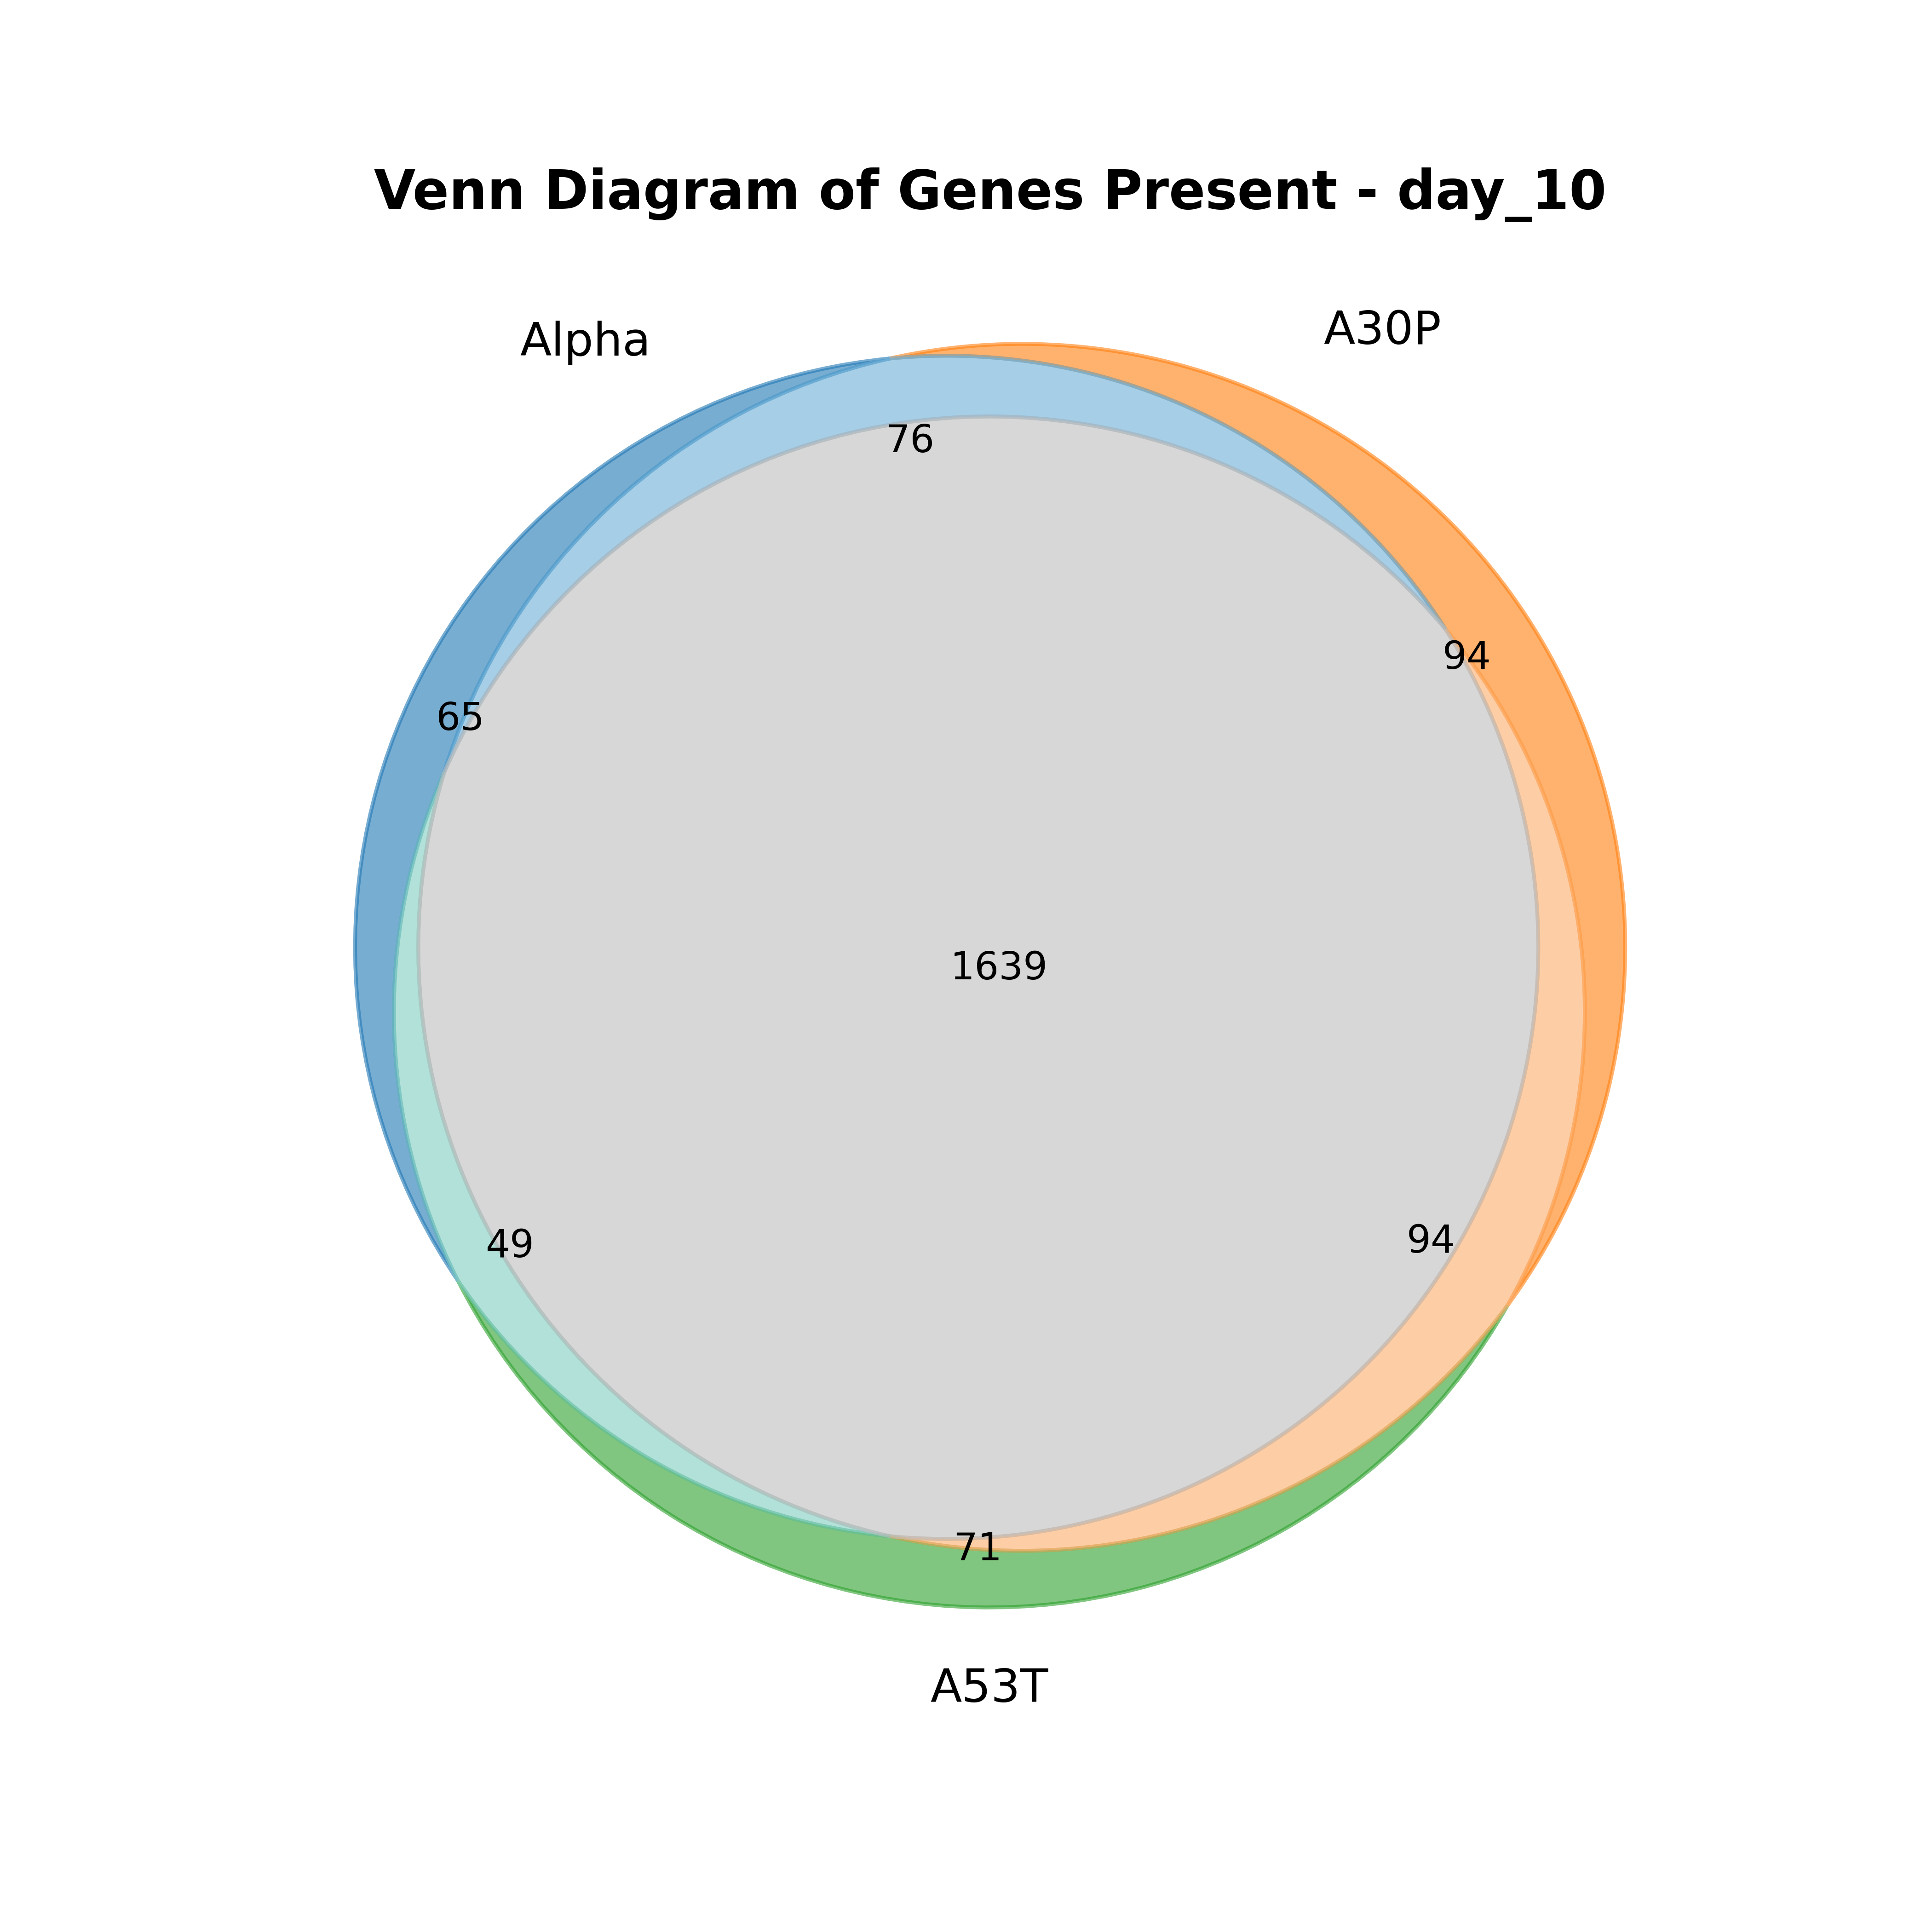

In [54]:
from IPython.display import Image
Image(filename='Venn_Diagram_day_10.png')


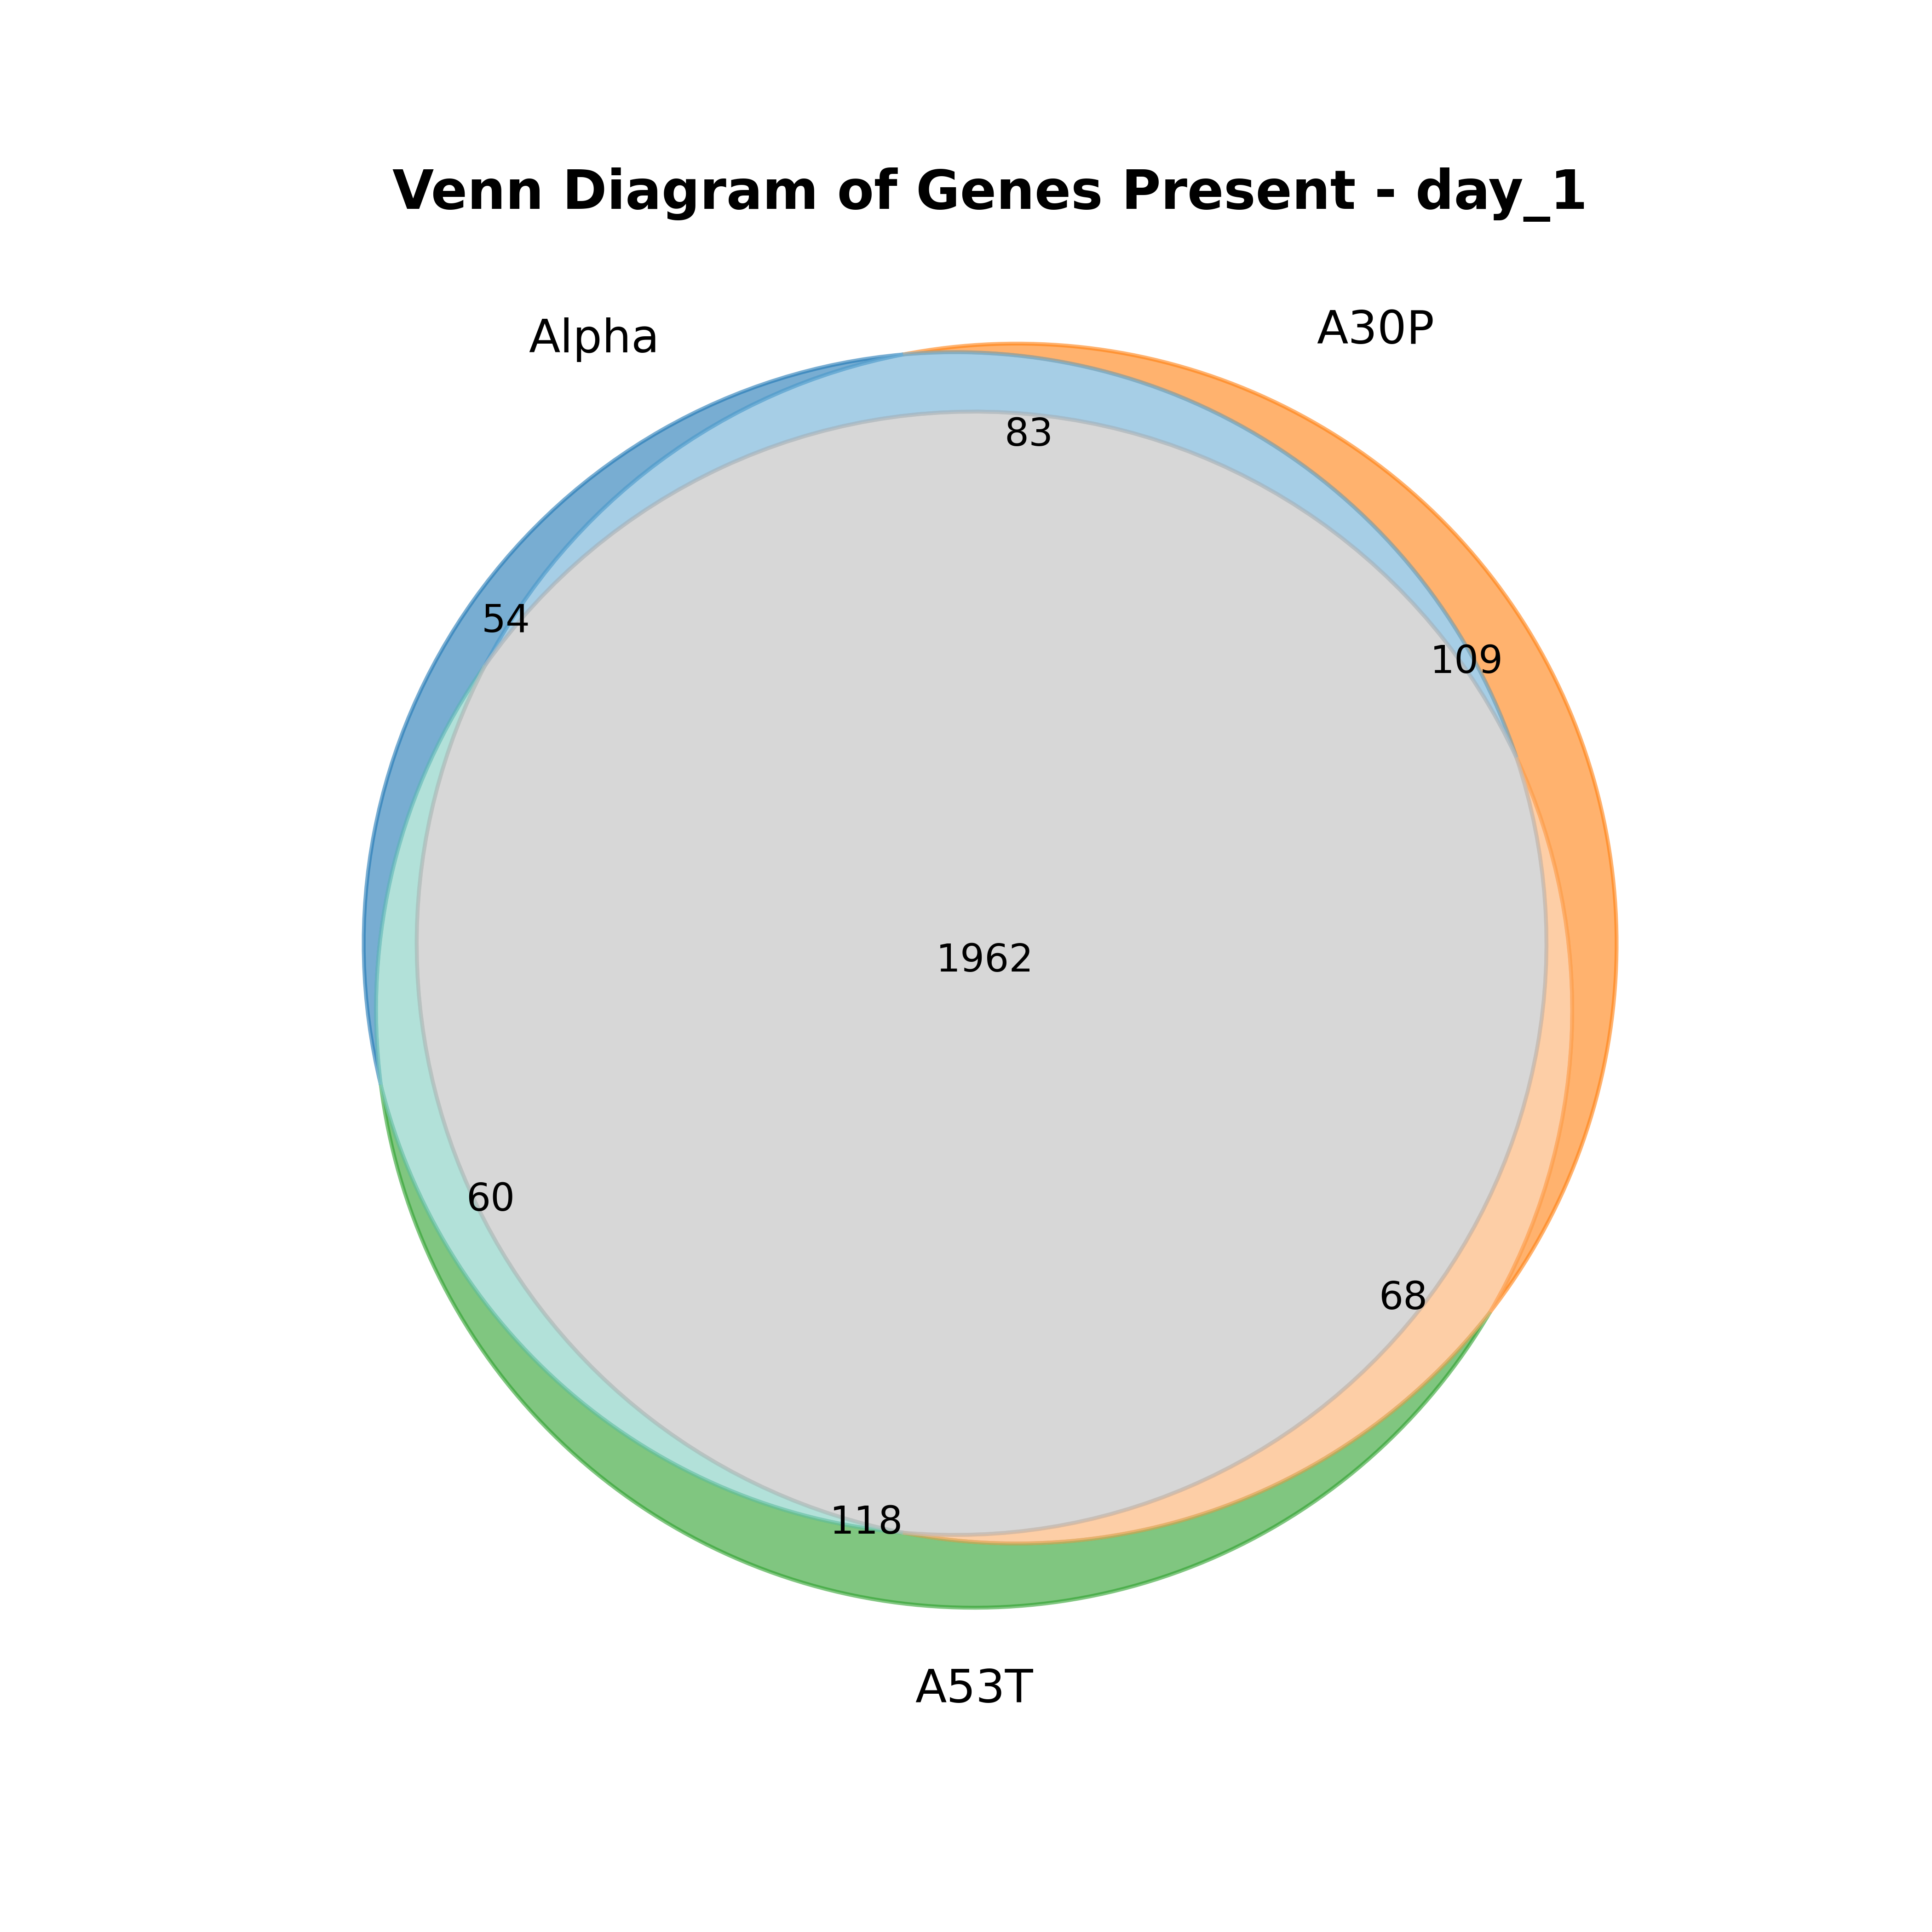

In [55]:
from IPython.display import Image
Image(filename='Venn_Diagram_day_1.png')


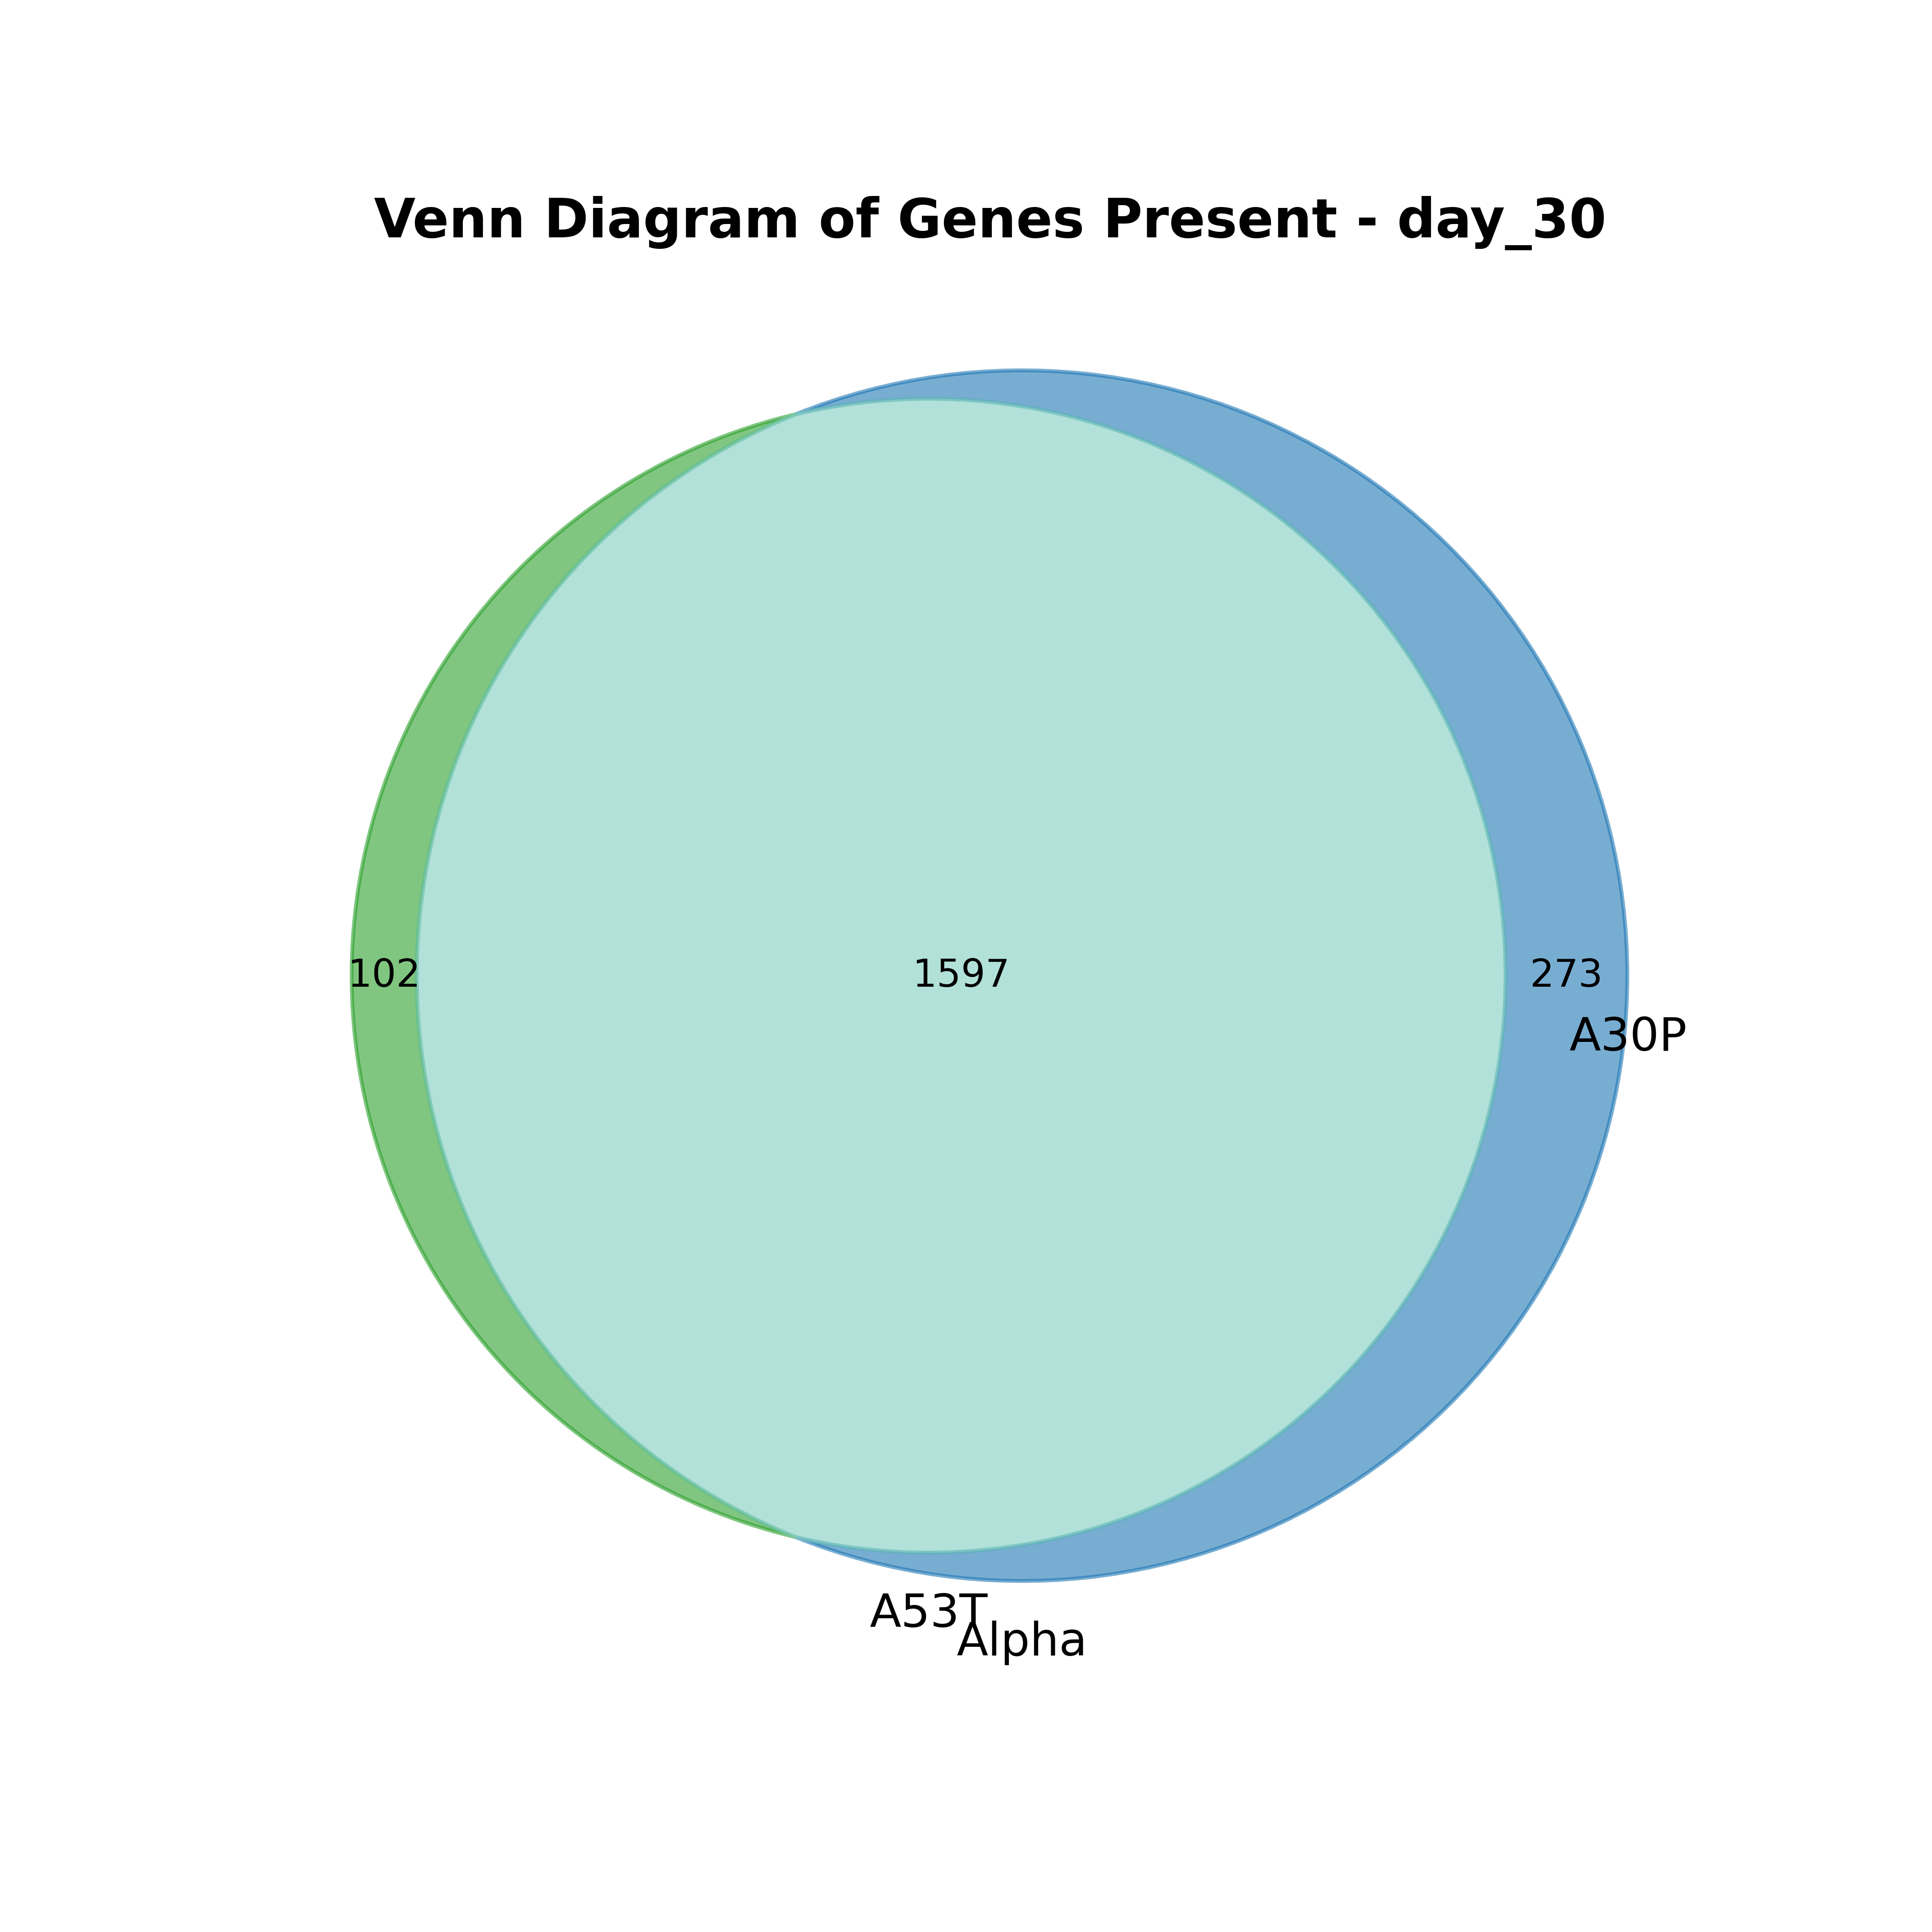

In [56]:
from IPython.display import Image
Image(filename='Venn_Diagram_day_30.png')


In [58]:
import re
import pandas as pd

# Define presence rule
THRESH = 0

# --- Re-generate sets for day_10 ---
day = 'day_10'

sample_A_cols = [col for col in df.columns if 'Alpha' in col and day in col and 'A30P' not in col and 'A53T' not in col]
sample_B_cols = [col for col in df.columns if 'A30P' in col and day in col]
sample_C_cols = [col for col in df.columns if 'A53T' in col and day in col]

set_A = set()
set_B = set()
set_C = set()

if sample_A_cols:
    mask_A = (df[sample_A_cols].notna() & (df[sample_A_cols] > THRESH)).any(axis=1)
    set_A = set(df.loc[mask_A, "Gene names"].astype(str).dropna())

if sample_B_cols:
    mask_B = (df[sample_B_cols].notna() & (df[sample_B_cols] > THRESH)).any(axis=1)
    set_B = set(df.loc[mask_B, "Gene names"].astype(str).dropna())

if sample_C_cols:
    mask_C = (df[sample_C_cols].notna() & (df[sample_C_cols] > THRESH)).any(axis=1)
    set_C = set(df.loc[mask_C, "Gene names"].astype(str).dropna())

# --- Get common genes ---
common_genes = list(set_A & set_B & set_C)

if len(common_genes) > 0:
    print(f"Total common genes for {day}: {len(common_genes)}")
    print(f"First two common genes for {day}: {common_genes[:2]}")
else:
    print(f"No common genes found for {day}.")


Total common genes for day_10: 1639
First two common genes for day_10: ['Galpha49B', 'unc-104']


In [59]:
import re
import pandas as pd

# Define presence rule
THRESH = 0

# --- Re-generate sets for day_1 ---
day = 'day_1'

sample_A_cols = [col for col in df.columns if 'Alpha' in col and day in col and 'A30P' not in col and 'A53T' not in col]
sample_B_cols = [col for col in df.columns if 'A30P' in col and day in col]
sample_C_cols = [col for col in df.columns if 'A53T' in col and day in col]

set_A = set()
set_B = set()
set_C = set()

if sample_A_cols:
    mask_A = (df[sample_A_cols].notna() & (df[sample_A_cols] > THRESH)).any(axis=1)
    set_A = set(df.loc[mask_A, "Gene names"].astype(str).dropna())

if sample_B_cols:
    mask_B = (df[sample_B_cols].notna() & (df[sample_B_cols] > THRESH)).any(axis=1)
    set_B = set(df.loc[mask_B, "Gene names"].astype(str).dropna())

if sample_C_cols:
    mask_C = (df[sample_C_cols].notna() & (df[sample_C_cols] > THRESH)).any(axis=1)
    set_C = set(df.loc[mask_C, "Gene names"].astype(str).dropna())

# --- Get common genes ---
common_genes_day1 = list(set_A & set_B & set_C)

if len(common_genes_day1) > 0:
    print(f"Total common genes for {day}: {len(common_genes_day1)}")
    print(f"Common genes for {day}: {common_genes_day1[:10]}") # Displaying first 10 for brevity
else:
    print(f"No common genes found for {day}.")


Total common genes for day_1: 1962
Common genes for day_1: ['Galpha49B', 'unc-104', 'ScpX', 'cin', 'Arf51F', 'mRpS18A', 'CG7740', 'nudC', 'Rfabg', 'HIP-R;HIP']
